# RAPIDS + AtacWorks Visualization of Single-cell Chromatin Accessibility

Copyright (c) 2020, NVIDIA CORPORATION.
Licensed under the Apache License, Version 2.0 (the "License") you may not use this file except in compliance with the License. You may obtain a copy of the License at

http://www.apache.org/licenses/LICENSE-2.0 

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

The dataset we use here was made public by 10X Genomics. It contains single-cell ATAC-seq data from approximately 5000 human PBMCs. We will use the peak x cell matrix for clustering the population and the fragment file to calculate and visualize chromatin accessibility in each cluster. 

In this demonstration, we first cluster the PBMC cells similarly to previous examples. Next, we use cuDF to calculate and visualize chromatin accessibility in selected marker regions for multiple clusters. Finally, we use AtacWorks, a deep learning model to improve the accuracy of the chromatin accessibility track and call peaks in individual clusters. We show how AtacWorks can be used to characterize rare populations of cells and identify cell-type specific peaks.

The code for AtacWorks is available [here](https://github.com/clara-parabricks/AtacWorks) and the method is described in detail in [this preprint](https://www.biorxiv.org/content/10.1101/829481v2). AtacWorks is available to run only on NVIDIA GPUs.

## Import requirements

In [1]:
import scanpy as sc
import anndata
import numpy as np
import pandas as pd

import time
import os, wget

import cudf
import cupy as cp
from cuml.decomposition import PCA

import matplotlib.pyplot as plt

import coverage
import utils

import warnings
warnings.filterwarnings('ignore', 'Expected ')

Matplotlib is building the font cache; this may take a moment.


In [2]:
import rmm
rmm.reinitialize(
   managed_memory=True, # Allows oversubscription
   devices=0, # GPU device IDs to register. By default registers only GPU 0.
)
cp.cuda.set_allocator(rmm.rmm_cupy_allocator)

## Downloads

### scATAC data

We download a single-cell ATAC-seq dataset of 5000 PBMCs from the 10X genomics website. Specifically, we download the fragment file (for generating coverage tracks) and the peak x cell matrix (for clustering).

In [3]:
FRAGMENT_FILE = '../data/5k_pbmcs_10X_fragments.tsv.gz'
FRAGMENT_INDEX_FILE = '../data/5k_pbmcs_10X_fragments.tsv.gz.tbi'
MATRIX_FILE = '../data/5k_pbmcs_10X.sparse.h5ad'

In [4]:
%%time

if not os.path.exists(MATRIX_FILE):
    print('Downloading Peak x cell matrix...')
    os.makedirs('../data', exist_ok=True)
    wget.download('https://rapids-single-cell-examples.s3.us-east-2.amazonaws.com/5k_pbmcs_10X.sparse.h5ad', MATRIX_FILE)

if not os.path.exists(FRAGMENT_FILE):
    print('Downloading fragment file...')
    wget.download('https://rapids-single-cell-examples.s3.us-east-2.amazonaws.com/5k_pbmcs_10X_fragments.tsv.gz', FRAGMENT_FILE)
    wget.download('https://rapids-single-cell-examples.s3.us-east-2.amazonaws.com/5k_pbmcs_10X_fragments.tsv.gz.tbi', FRAGMENT_INDEX_FILE)

CPU times: user 419 µs, sys: 1.13 ms, total: 1.55 ms
Wall time: 91.3 ms


### AtacWorks trained model

We also download a trained AtacWorks model. This model is trained using low-coverage ATAC-seq data with a sequencing depth of ~5 million reads.

In [5]:
ATACWORKS_MODEL_FILE = '../models/model.pth.tar'

In [6]:
%%time

if not os.path.exists(ATACWORKS_MODEL_FILE):
    print('Downloading AtacWorks model weights...')
    os.makedirs('../models', exist_ok=True)
    wget.download('https://api.ngc.nvidia.com/v2/models/nvidia/atac_bulk_lowcov_5m_50m/versions/0.3/files/models/model.pth.tar', ATACWORKS_MODEL_FILE)

CPU times: user 1.09 ms, sys: 0 ns, total: 1.09 ms
Wall time: 53.4 ms


## Set parameters for analysis

In [7]:
# Number of peaks to retain
n_top_peaks = 20000

# PCA
n_components = 50

# KNN
n_neighbors=25
knn_n_pcs=50

# UMAP
umap_min_dist=0.3

### Set AtacWorks parameters

In [8]:
# Index of GPU to use for AtacWorks model
gpu = 0

# Parameters for use of the AtacWorks model
interval_size = 50000
pad = 0

In [9]:
start_time = time.time()

## Load count matrix

In [10]:
%%time
adata = sc.read(MATRIX_FILE)
adata

CPU times: user 147 ms, sys: 249 ms, total: 396 ms
Wall time: 12.4 s


AnnData object with n_obs × n_vars = 4654 × 84626

## Preprocessing

For more information on these preprocessing steps, please refer to Example 4: Droplet single-cell ATAC-seq of 60K bone marrow cells from Lareau et al. 2019.

In [11]:
preprocessing_start = time.time()

### tf-idf normalization

In [12]:
%%time
lognormalized = utils.logtf_idf(adata.X, pseudocount=10**3)
adata.X = lognormalized

CPU times: user 960 ms, sys: 24.2 s, total: 25.2 s
Wall time: 27.8 s


### Frequency-based peak selection

In [13]:
%%time
adata = utils.filter_peaks(adata, n_top_peaks)
print(adata.X.shape)

(4654, 20000)
CPU times: user 603 ms, sys: 137 ms, total: 740 ms
Wall time: 739 ms


In [14]:
print("Preprocessing time: %.2fsec" % (time.time() - preprocessing_start))

Preprocessing time: 28.54sec


## Cluster & Visualize

### PCA

In [15]:
%%time
adata = anndata.AnnData(X=adata.X.todense(), obs=adata.obs,var=adata.var)
adata.obsm["X_pca"] = PCA(n_components=n_components).fit_transform(adata.X)
adata.obsm["X_pca"].shape

CPU times: user 11.3 s, sys: 10.5 s, total: 21.9 s
Wall time: 1min 22s


(4654, 50)

### UMAP

In [16]:
%%time
sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=knn_n_pcs, method='rapids')

CPU times: user 5.79 s, sys: 14 s, total: 19.8 s
Wall time: 23.4 s


In [17]:
%%time
sc.tl.umap(adata, min_dist=umap_min_dist, method='rapids')

CPU times: user 478 ms, sys: 490 ms, total: 968 ms
Wall time: 8.34 s


### Louvain clustering

In [18]:
%%time
sc.tl.louvain(adata, flavor='rapids')

CPU times: user 4.11 s, sys: 2.15 s, total: 6.26 s
Wall time: 1min 30s


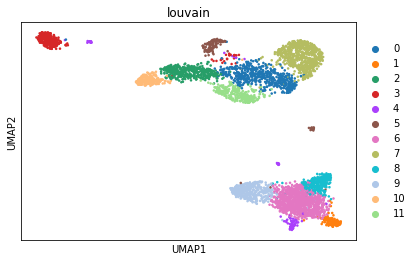

In [19]:
sc.pl.umap(adata, color=['louvain'])

We can view the cluster assignment for each barcode:

In [20]:
%%time
clusters = pd.Series(adata.obs['louvain']).reset_index()
clusters.columns = ['cell', 'cluster']
cluster_ids = np.unique(clusters.cluster)
clusters.head()

CPU times: user 4.54 ms, sys: 601 µs, total: 5.14 ms
Wall time: 5.03 ms


,cell,cluster
0,AAACGAAAGCGCAATG-1,8
1,AAACGAAAGGGTATCG-1,6
2,AAACGAAAGTAACATG-1,0
3,AAACGAAAGTTACACC-1,11
4,AAACGAACAGAGATGC-1,6


## Read fragments covering specified region

For this demonstration, we select a 100-kb region (including part of the MS4A1 marker gene) on chromosome 11. 

In [21]:
chrom = 'chr11'
start = 60170000
end = 60270000

We use tabix to read all fragments overlapping this region from the fragments file. In order to match fragments to clusters, we merge the dataframe containing fragments with the cluster assignments.

In [22]:
%%time
fragments = coverage.read_fragments(chrom, start, end, FRAGMENT_FILE)
fragments = fragments.merge(cudf.DataFrame(clusters), on=['cell'])
print(str(len(fragments)) + ' fragments were read from ' + FRAGMENT_FILE + '.')
fragments.head()

1301 fragments were read from ../data/5k_pbmcs_10X_fragments.tsv.gz.
CPU times: user 3.92 s, sys: 129 ms, total: 4.05 s
Wall time: 7.15 s


,chrom,start,end,cell,row_num,len,cluster
0,chr11,60214195,60214266,TGTAGCAGTACTAGAA-1,596,71,10
1,chr11,60266237,60266492,TGTGACAAGTAGAAGG-1,2014,255,4
2,chr11,60266468,60266506,TGTGACAGTCATGAGG-1,2058,38,11
3,chr11,60181444,60181855,TGTGACAGTGGACAGT-1,116,411,2
4,chr11,60250065,60250418,TGTGGCGGTAGGTGAC-1,1636,353,6


## Calculate per-base sequencing coverage

We use cuDF to count the number of fragments overlapping each base in our selected region, in each cluster.

In [23]:
%%time
region_coverage = coverage.get_coverages(start, end, fragments)
print(region_coverage.shape)
region_coverage

(12, 100000)
CPU times: user 3.12 s, sys: 64.6 ms, total: 3.19 s
Wall time: 6.06 s


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

## Plot per-base sequencing coverage

Below, we visualize this unsmoothed measure of chromatin accessibility across our selected region.

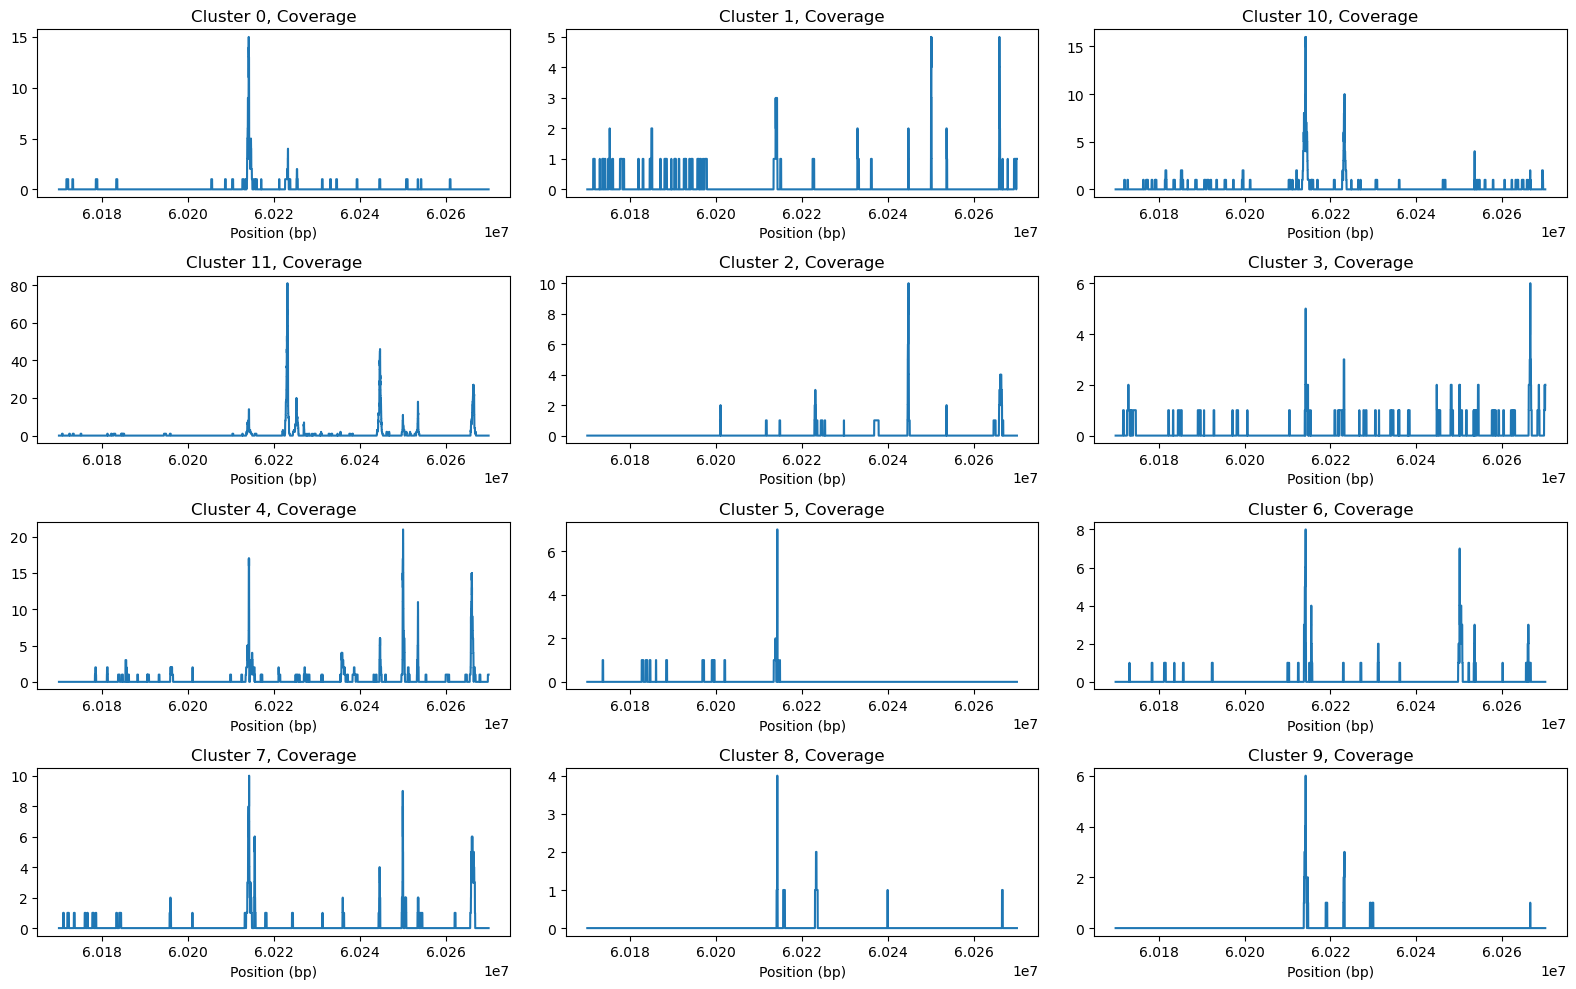

In [24]:
fig, axs = plt.subplots(ncols = 3, nrows = 4, figsize = (16, 10), dpi=100)
axs = axs.flatten()
coords = np.arange(start, end)

for (i, cluster) in enumerate(cluster_ids):
    axs[i].plot(coords, region_coverage[i,:])
    axs[i].set_title(f'Cluster {cluster}, Coverage')
    axs[i].set_xlabel('Position (bp)')
    
plt.tight_layout()
plt.show()

## Denoising and peak calling in selected clusters using AtacWorks

In [25]:
atacworks_start_time = time.time()

### Count fragments per cluster

First we count the number of fragments per barcode. Then, we match these to the cluster assignments of the respective barcodes in order to sum the total number of fragments for all barcodes within each cluster.

In [26]:
%%time
barcode_counts = coverage.count_fragments(FRAGMENT_FILE)
barcode_counts.head()

CPU times: user 1min 14s, sys: 1.22 s, total: 1min 15s
Wall time: 1min 16s


,cell,fragments
0,GTGCACGGTGTTGTTG-1,382101
1,AACTGGTAGCTCCGGT-1,339624
2,ACTGCAAGTGCTTACA-1,328598
3,GCACCTTTCCAACGCG-1,322845
4,CCGTGAGAGACCATAA-1,319897


In [27]:
%%time
cluster_counts = clusters.merge(barcode_counts, on='cell').groupby('cluster').sum()
cluster_counts

CPU times: user 375 ms, sys: 0 ns, total: 375 ms
Wall time: 431 ms


,fragments
cluster,
0,11330018
1,1340349
2,10137117
3,3713601
4,1751651
5,4811868
6,10072509
7,10111453
8,3242502


### Select clusters for AtacWorks

For this demonstration, we will select two clusters with close to 5 million reads. We will denoise the coverage track and call peaks for these clusters using the AtacWorks model trained on 5 million reads.

In [28]:
%%time
num_clusters_to_denoise = 2
clusters_to_denoise = abs(cluster_counts.fragments - 5000000).sort_values().iloc[:num_clusters_to_denoise].index.to_list()
print(clusters_to_denoise)

['5', '11']
CPU times: user 2.46 ms, sys: 0 ns, total: 2.46 ms
Wall time: 2.31 ms


In [29]:
%%time
noisy_coverage = region_coverage[np.isin(cluster_ids, clusters_to_denoise)]
print(noisy_coverage.shape)

(2, 100000)
CPU times: user 1.8 ms, sys: 0 ns, total: 1.8 ms
Wall time: 1.18 ms


In [30]:
noisy_coverage

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

### Load AtacWorks model

In [31]:
%%time
model = coverage.load_atacworks_model(ATACWORKS_MODEL_FILE, gpu, interval_size)

Loading model weights from ../models/model.pth.tar...
Finished loading.
CPU times: user 37 ms, sys: 21.9 ms, total: 59 ms
Wall time: 699 ms


### Inference using trained model

In [32]:
%%time
atacworks_results = coverage.atacworks_denoise(noisy_coverage, model, gpu, interval_size)
track_pred = atacworks_results[:, :, 0].reshape(num_clusters_to_denoise, (end-start))
peak_pred = atacworks_results[:, :, 1].reshape(num_clusters_to_denoise, (end-start))

CPU times: user 146 ms, sys: 45.5 ms, total: 192 ms
Wall time: 670 ms


In [33]:
print("AtacWorks time: %.2fsec" % (time.time() - atacworks_start_time))

AtacWorks time: 78.55sec


### Plot results

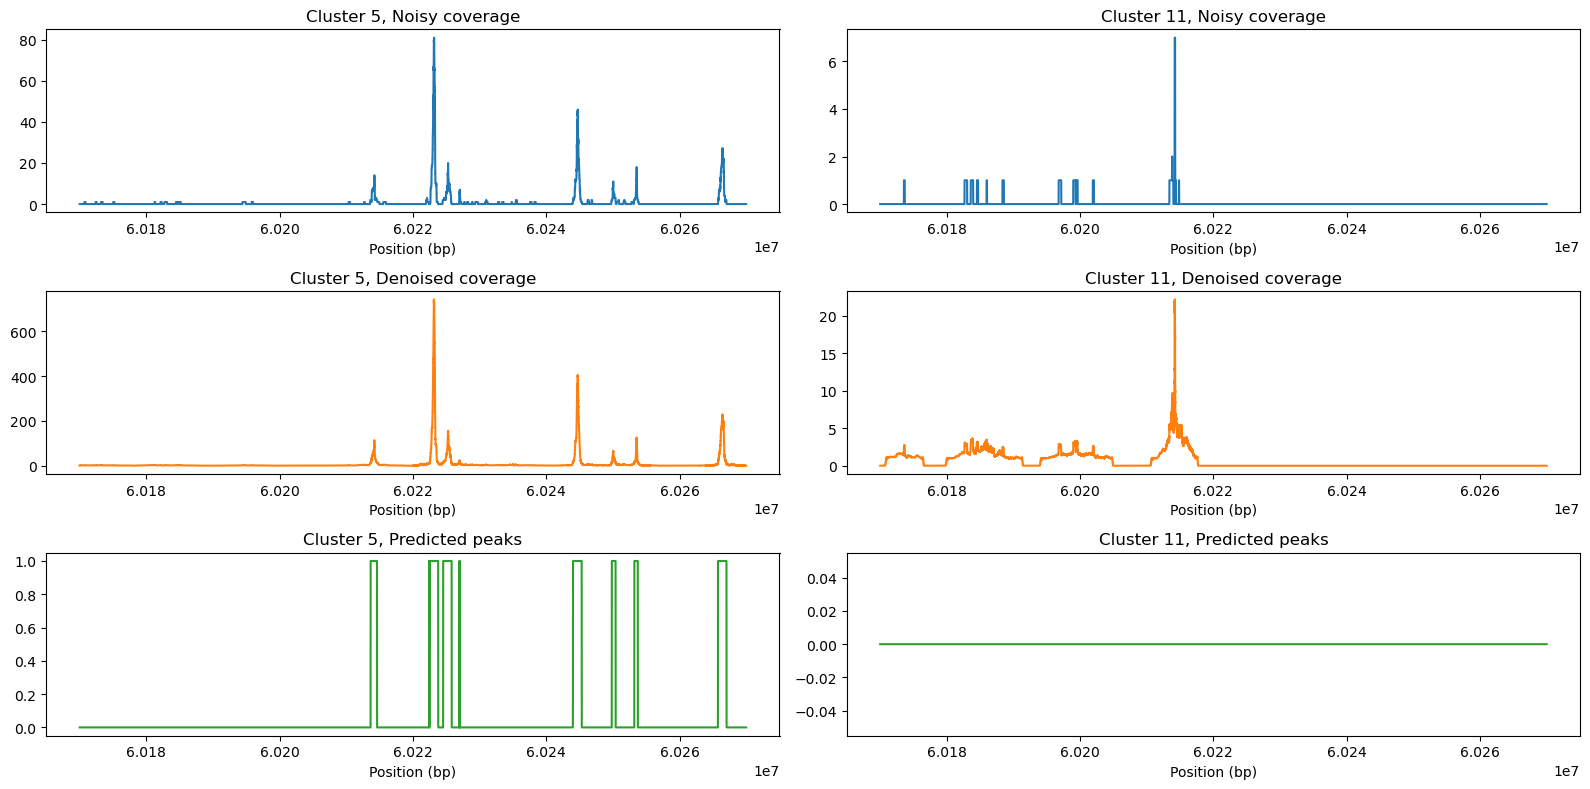

CPU times: user 1.31 s, sys: 578 ms, total: 1.89 s
Wall time: 3.7 s


In [34]:
%%time

fig, axs = plt.subplots(ncols = 2, nrows = 3, figsize = (16, 8), dpi=100)

coords = np.arange(start, end)

for (i, cluster) in enumerate(clusters_to_denoise):
    axs[0][i].plot(coords, noisy_coverage[i])
    axs[0][i].set_title(f'Cluster {cluster}, Noisy coverage')
    axs[0][i].set_xlabel('Position (bp)')
    
    axs[1][i].plot(coords, track_pred[i], color='C1')
    axs[1][i].set_title(f'Cluster {cluster}, Denoised coverage')
    axs[1][i].set_xlabel('Position (bp)')
    
    axs[2][i].plot(coords, peak_pred[i] > 0.5, color='C2')
    axs[2][i].set_title(f'Cluster {cluster}, Predicted peaks')
    axs[2][i].set_xlabel('Position (bp)')
    
plt.tight_layout()
plt.show()

In [35]:
print("Full time: %.2fsec" % (time.time() - start_time))

Full time: 350.54sec
